**Bayesian spam filter**

In [1]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
mails = pd.read_csv("spam.csv", encoding="latin-1")
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
mails = mails.rename(columns={'v1': 'label', 'v2': 'text'})
mails.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


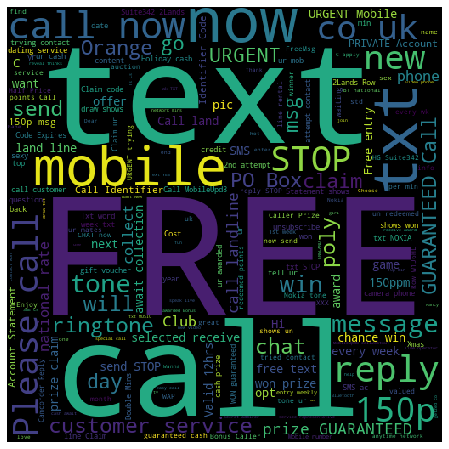

In [3]:
from wordcloud import WordCloud

spam_words = ' '.join(list(mails[mails['label'] == 'spam']['text']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)  # word density
plt.figure(figsize=(10, 8))
plt.imshow(spam_wc)
plt.axis("off")
plt.show()

In [4]:
mails.groupby('label').describe()  # 15% spam; duplication

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A75607AC8>,
      dtype=object)

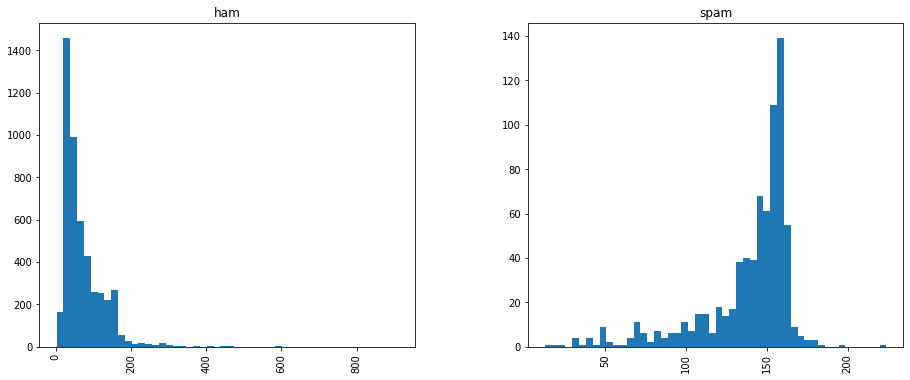

In [5]:
mails['length'] = mails['text'].map(len)
mails.hist(column='length', by='label', bins=50, figsize=(15, 6))  # length difference

In [6]:
import string

def process_text(text):
    # remove punctuation & tokenize
    remove = [c for c in text if c not in string.punctuation]
    nopunc = ''.join(remove)
    
    # remove stopwords
    clean = [word for word in nopunc.split() if word.lower not in stopwords.words("english")]
    
    return clean

mails['text'].map(process_text).head()

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, dont, think, he, goes, to, usf, he, l...
Name: text, dtype: object

In [8]:
# train / test split
mtrain, mtest, train_label, test_label = train_test_split(mails['text'], mails['label'], test_size=0.25)

In [15]:
# list of (name, transform) tuples (implementing fit/transform)
pipeline = Pipeline([('vec', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('nb', MultinomialNB())])

In [16]:
pipeline.fit(mtrain, train_label)

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer=<function process_text at 0x0000024A75A761E0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...linear_tf=False, use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [17]:
predictions = pipeline.predict(mtest)
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      1194
        spam       1.00      0.63      0.77       199

   micro avg       0.95      0.95      0.95      1393
   macro avg       0.97      0.81      0.87      1393
weighted avg       0.95      0.95      0.94      1393



In [13]:
# without preprocessing
# punctutations can be useful for spam classification
print(classification_report(test_label, predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1194
        spam       1.00      0.71      0.83       199

   micro avg       0.96      0.96      0.96      1393
   macro avg       0.98      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



**Optical character recognition**

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
display.set_matplotlib_formats("svg")

import torch
from torch import tensor
from torchvision import transforms, datasets

data_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize(mean=[0], std=[1])])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=data_transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=data_transform)

0.2%

100.1%

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz


0.5%5%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz


100.4%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [19]:
mnist_train.data.size()

torch.Size([60000, 28, 28])

In [20]:
len(set(mnist_train.targets.numpy()))

10

In [21]:
xcount = torch.ones(28 ** 2, 10, dtype=torch.float32)  # Laplace smoothing
ycount = torch.ones(10, dtype=torch.float32)

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:, y] += data.reshape(784)
    
py = ycount / ycount.sum()
px = xcount / ycount 

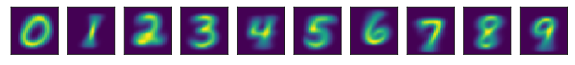

Class probabilities: tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [22]:
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape(28, 28).numpy())
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)
    
plt.show()
print("Class probabilities:", py)

In [23]:
# first test item
data, label = mnist_test[0]
data = data.reshape(784, 1)

# numerical underflow
xprob = (px * data + (1 - px) * (1 - data)) # p(x_i|y) conditional prob per pixel
xprob = xprob.prod(0) * py  # product per image p(x|y) * p(y)
xprob = xprob / xprob.sum()  # normalize
xprob

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [24]:
# use logrithm to change the product to sum (log ab = loga + logb)
logpx = torch.log(px)
logpx_neg = torch.log(1 - px)
logpy = torch.log(py)

def bayes_post(data):
    logpost = logpy.clone()
    logpost += (logpx * data + logpx_neg * (1 - data)).sum(0)  # log Sum(log p(x_i|y)) + log py
    # normalize to prevent overflow or underflow by subtracting max
    logpost -= torch.max(logpost)
    # softmax e^i / sum(e^i)
    post = torch.exp(logpost).numpy() / sum(torch.exp(logpost).numpy())
    return post

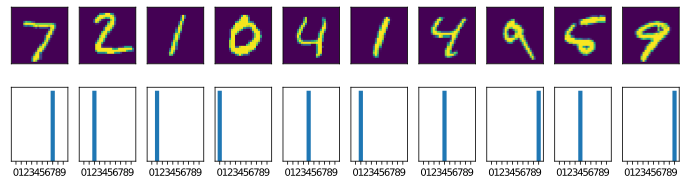

prediction:  7; 2; 1; 0; 4; 1; 4; 9; 4; 9; 
label:  7; 2; 1; 0; 4; 1; 4; 9; 5; 9; 


In [25]:
fig, figarr = plt.subplots(2, 10, figsize=(12, 3))

pred = ""
ans = ""
n = 0

for data, label in mnist_test:
    figarr[0][n].imshow(data.reshape(28, 28))
    figarr[0][n].axes.get_xaxis().set_visible(False)
    figarr[0][n].axes.get_yaxis().set_visible(False)
    
    p = bayes_post(data.reshape(784, 1))
    pred += str(np.argmax(p)) + "; "
    ans += str(label) + "; "
    
    figarr[1][n].bar(range(10), p)
    figarr[1][n].axes.set_xticks(np.arange(0, 10))
    figarr[1][n].axes.get_yaxis().set_visible(False)
    n += 1
    if n == 10:
        break

plt.show()
print("prediction: ", pred)
print("label: ", ans)

In [26]:
n = 0
err = 0

for data, label in mnist_test:
    post = bayes_post(data.reshape(784, 1))
    if np.argmax(post) != int(label):
        err += 1
    n += 1

print("Naive Bayes has an error rate of ", err / n)

Naive Bayes has an error rate of  0.1553
